# Solar Panel Readings Visualization

This notebook visualizes real-time solar panel readings from the TimescaleDB database. We'll analyze voltage, current, power, and temperature data over time.

## 🔐 Security Configuration

This notebook uses secure credential management for database access:

1. **Primary method**: Uses the app's configuration system (`app.core.config.Settings`)
2. **Fallback method**: Environment variables for database credentials
3. **No hardcoded passwords**: All sensitive information is externalized

### Environment Variables (if needed):
```bash
export TIMESCALE_HOST="your_host"
export TIMESCALE_PORT="6543"
export TIMESCALE_DATABASE="solar_monitor"
export TIMESCALE_USER="your_username" 
export TIMESCALE_PASSWORD="your_secure_password"
```

The notebook will automatically detect and use the most secure available credential source.

In [2]:
# Import Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import psycopg2
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timezone, timedelta
import numpy as np

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [1]:
# Install Required Packages (run this cell first if packages are missing)
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    'pandas',
    'matplotlib', 
    'plotly',
    'psycopg2-binary',
    'seaborn',
    'sqlalchemy'  # Added for better database connectivity
]

# Check and install missing packages
missing_packages = []
for package in required_packages:
    try:
        if package == 'psycopg2-binary':
            __import__('psycopg2')  # psycopg2-binary imports as psycopg2
        else:
            __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        missing_packages.append(package)
        print(f"❌ {package} is missing")

if missing_packages:
    print(f"\n📦 Installing missing packages: {missing_packages}")
    for package in missing_packages:
        try:
            install_package(package)
            print(f"✅ Successfully installed {package}")
        except Exception as e:
            print(f"❌ Failed to install {package}: {e}")
else:
    print("🎉 All required packages are available!")

✅ pandas is already installed
✅ matplotlib is already installed
✅ plotly is already installed
✅ psycopg2-binary is already installed
✅ seaborn is already installed
✅ sqlalchemy is already installed
🎉 All required packages are available!


In [4]:
# Load Data from TimescaleDB Database (Secure Credentials)
import os
import sys
from sqlalchemy import create_engine, text
import warnings

# Add the project path to access the config module
sys.path.append('/home/julianelliott/solar-monitor')

def get_database_config():
    """Get database configuration from environment variables or config file"""
    try:
        # Try to use the app's configuration system
        from app.core.config import Settings
        settings = Settings()
        return {
            'host': settings.timescale_host,
            'port': settings.timescale_port,
            'database': settings.timescale_database,
            'user': settings.timescale_user,
            'password': settings.timescale_password
        }
    except Exception as e:
        print(f"⚠️ Could not load app config: {e}")
        
        # Fallback to environment variables
        config = {
            'host': os.getenv('TIMESCALE_HOST', 'localhost'),
            'port': int(os.getenv('TIMESCALE_PORT', 5432)),
            'database': os.getenv('TIMESCALE_DATABASE', 'solar_monitor'),
            'user': os.getenv('TIMESCALE_USER', 'postgres'),
            'password': os.getenv('TIMESCALE_PASSWORD')
        }
        
        if not config['password']:
            print("❌ No database password found in environment variables!")
            print("Please set TIMESCALE_PASSWORD environment variable or ensure app config is available")
            return None
            
        return config

# Load Data from TimescaleDB Database
def load_solar_data(hours_back=2):
    """Load solar panel readings from TimescaleDB using secure credentials"""
    
    # Get database configuration
    db_config = get_database_config()
    if not db_config:
        print("❌ Could not get database configuration")
        return None
    
    try:
        # Create SQLAlchemy engine for better pandas compatibility
        engine = create_engine(
            f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
        )
        
        # Fixed SQL query with SQLAlchemy text() for parameter binding
        query = text("""
        SELECT 
            timestamp,
            voltage,
            current,
            power,
            temperature,
            efficiency,
            conditions
        FROM readings 
        WHERE timestamp >= NOW() - INTERVAL :hours_interval
        ORDER BY timestamp ASC
        """)
        
        # Load data into pandas DataFrame using SQLAlchemy engine
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")  # Suppress pandas warnings
            df = pd.read_sql_query(
                query, 
                engine, 
                params={'hours_interval': f'{hours_back} hours'}
            )
        
        # Convert timestamp to datetime and set as index
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        print(f"✅ Loaded {len(df)} readings from the last {hours_back} hours")
        print(f"🔐 Connected to: {db_config['user']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")
        return df
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Load the data
df = load_solar_data(hours_back=2)
if df is not None:
    print(f"Data shape: {df.shape}")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
else:
    print("⚠️ No data loaded - check connection and credentials")

✅ Loaded 3369 readings from the last 2 hours
🔐 Connected to: Julian-elliott@192.168.42.125:6543/solar_monitor
Data shape: (3369, 6)
Time range: 2025-06-10 19:37:12.460842+00:00 to 2025-06-10 21:37:10.646485+00:00


In [5]:
# Preview the Data
if df is not None:
    print("📊 Data Overview:")
    print("=" * 50)
    
    # Display basic info
    print(f"Number of readings: {len(df)}")
    print(f"Data collection period: {df.index.max() - df.index.min()}")
    
    # Show first few rows
    print("\n🔍 First 5 readings:")
    display(df.head())
    
    # Show basic statistics
    print("\n📈 Summary Statistics:")
    display(df.describe().round(4))
    
    # Check for any missing values
    print(f"\n🔍 Missing values: {df.isnull().sum().sum()}")
else:
    print("❌ No data available to preview")

📊 Data Overview:
Number of readings: 3369
Data collection period: 0 days 01:59:58.185643

🔍 First 5 readings:


,voltage,current,power,temperature,efficiency,conditions
timestamp,,,,,,
2025-06-10 19:37:12.460842+00:00,20.32,2.07,42.06,21.0,42.06,unknown
2025-06-10 19:37:13.536683+00:00,21.03,3.17,66.67,22.0,66.67,unknown
2025-06-10 19:37:14.635491+00:00,21.63,3.35,72.46,21.9,72.46,unknown
2025-06-10 19:37:15.727153+00:00,20.07,2.43,48.77,33.4,48.77,unknown
2025-06-10 19:37:16.827919+00:00,21.34,4.58,97.74,33.1,97.74,unknown



📈 Summary Statistics:


,voltage,current,power,temperature,efficiency
count,3369.0000,3369.0000,3369.0000,3369.0000,3369.0000
mean,5.7553,0.8691,17.3817,22.1139,17.3506
std,8.2922,1.5679,31.5071,4.3243,31.4229
min,0.0000,-0.0005,0.0000,15.0000,0.0000
25%,0.2700,0.0001,0.0001,20.5000,0.0001
50%,1.3309,0.0045,0.0010,20.7422,0.0010
75%,4.1344,0.0100,0.0050,23.5000,0.0050
max,21.9900,5.0000,109.5800,35.0000,100.0000



🔍 Missing values: 0


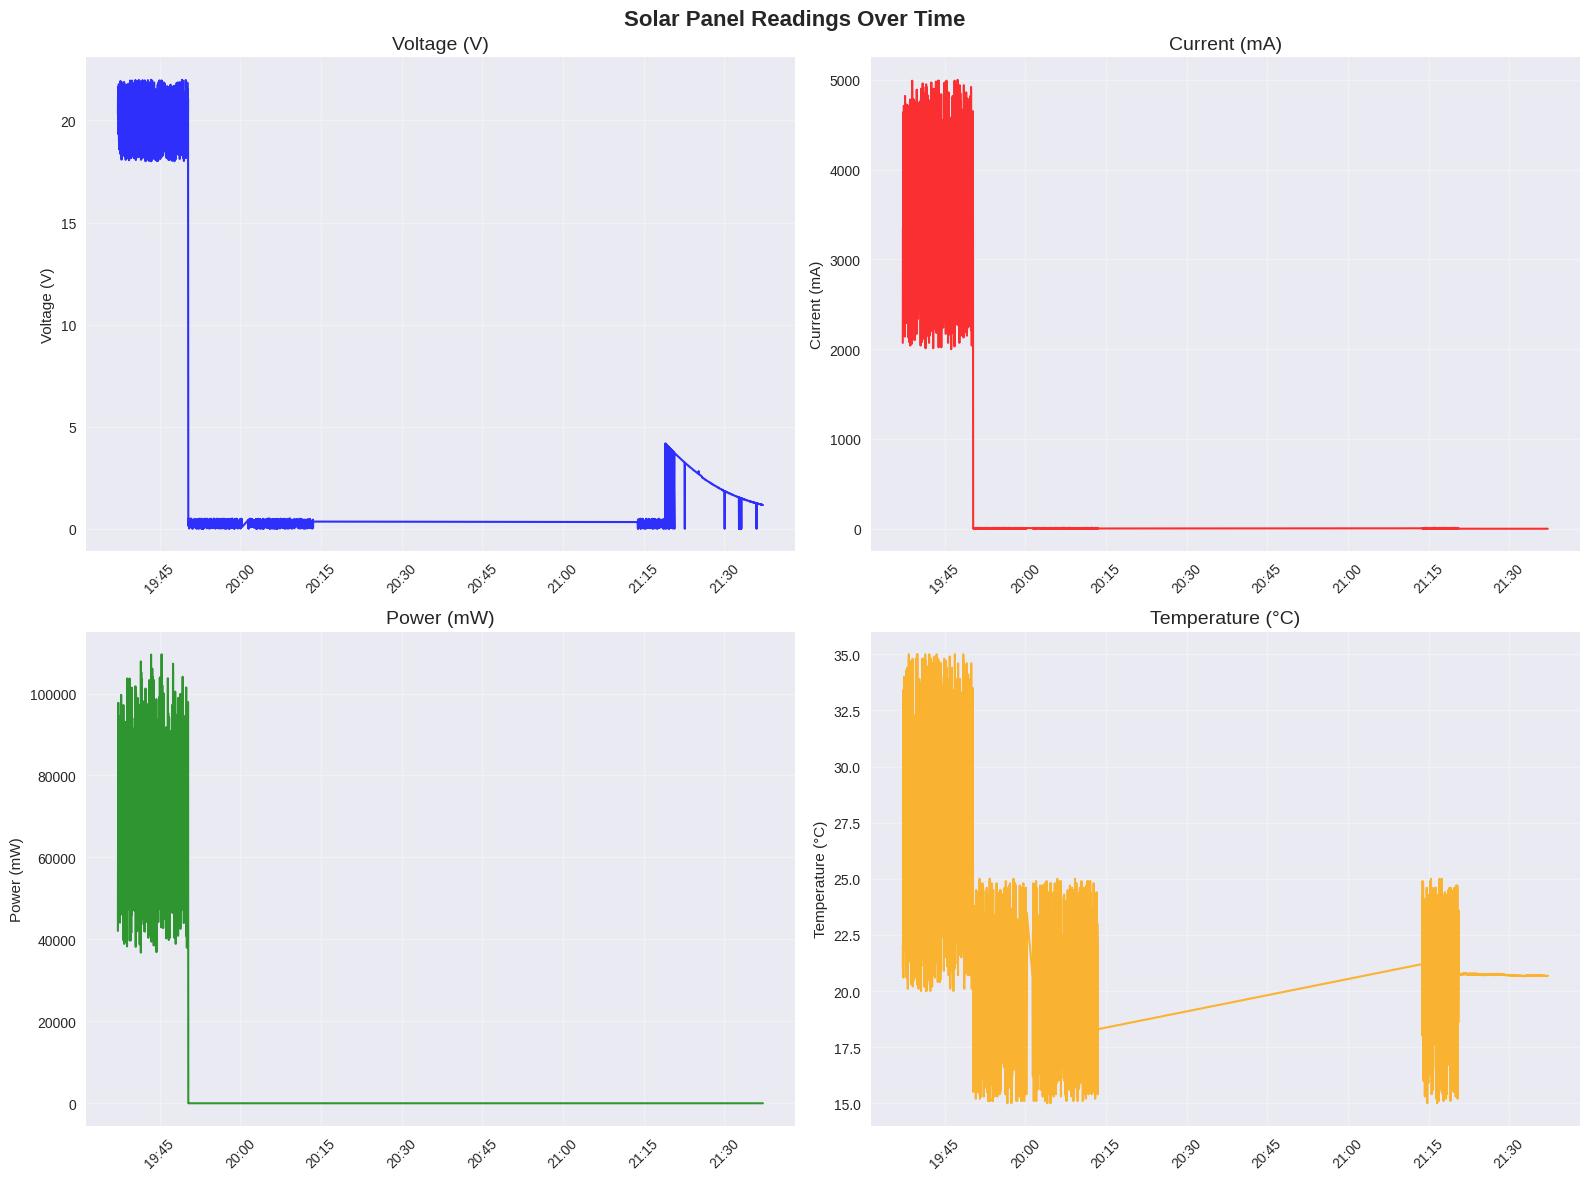

In [6]:
# Visualize the Data with Matplotlib
if df is not None and len(df) > 0:
    
    # Create subplots for different metrics
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Solar Panel Readings Over Time', fontsize=16, fontweight='bold')
    
    # 1. Voltage over time
    axes[0, 0].plot(df.index, df['voltage'], color='blue', linewidth=1.5, alpha=0.8)
    axes[0, 0].set_title('Voltage (V)', fontsize=14)
    axes[0, 0].set_ylabel('Voltage (V)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 2. Current over time
    axes[0, 1].plot(df.index, df['current'] * 1000, color='red', linewidth=1.5, alpha=0.8)  # Convert to mA
    axes[0, 1].set_title('Current (mA)', fontsize=14)
    axes[0, 1].set_ylabel('Current (mA)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 3. Power over time
    axes[1, 0].plot(df.index, df['power'] * 1000, color='green', linewidth=1.5, alpha=0.8)  # Convert to mW
    axes[1, 0].set_title('Power (mW)', fontsize=14)
    axes[1, 0].set_ylabel('Power (mW)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # 4. Temperature over time
    axes[1, 1].plot(df.index, df['temperature'], color='orange', linewidth=1.5, alpha=0.8)
    axes[1, 1].set_title('Temperature (°C)', fontsize=14)
    axes[1, 1].set_ylabel('Temperature (°C)')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    # Rotate x-axis labels for better readability
    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ No data available for visualization")

In [6]:
# Interactive Plotly Visualization
if df is not None and len(df) > 0:
    
    # Create subplots with Plotly
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Voltage (V)', 'Current (mA)', 'Power (mW)', 'Temperature (°C)'),
        vertical_spacing=0.1,
        horizontal_spacing=0.1
    )
    
    # Add voltage trace
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['voltage'],
            mode='lines',
            name='Voltage',
            line=dict(color='blue', width=2),
            hovertemplate='Time: %{x}<br>Voltage: %{y:.3f} V<extra></extra>'
        ),
        row=1, col=1
    )
    
    # Add current trace (in mA)
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['current'] * 1000,
            mode='lines',
            name='Current',
            line=dict(color='red', width=2),
            hovertemplate='Time: %{x}<br>Current: %{y:.3f} mA<extra></extra>'
        ),
        row=1, col=2
    )
    
    # Add power trace (in mW)
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['power'] * 1000,
            mode='lines',
            name='Power',
            line=dict(color='green', width=2),
            hovertemplate='Time: %{x}<br>Power: %{y:.3f} mW<extra></extra>'
        ),
        row=2, col=1
    )
    
    # Add temperature trace
    fig.add_trace(
        go.Scatter(
            x=df.index, 
            y=df['temperature'],
            mode='lines',
            name='Temperature',
            line=dict(color='orange', width=2),
            hovertemplate='Time: %{x}<br>Temperature: %{y:.1f} °C<extra></extra>'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig.update_layout(
        title='Real-Time Solar Panel Monitoring Dashboard',
        title_x=0.5,
        height=700,
        showlegend=False,
        hovermode='x unified'
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Time", row=2, col=1)
    fig.update_xaxes(title_text="Time", row=2, col=2)
    fig.update_yaxes(title_text="Voltage (V)", row=1, col=1)
    fig.update_yaxes(title_text="Current (mA)", row=1, col=2)
    fig.update_yaxes(title_text="Power (mW)", row=2, col=1)
    fig.update_yaxes(title_text="Temperature (°C)", row=2, col=2)
    
    fig.show()
    
else:
    print("❌ No data available for interactive visualization")

❌ No data available for interactive visualization


In [7]:
# Real-Time Data Analysis and Statistics
if df is not None and len(df) > 0:
    
    print("📊 Real-Time Solar Panel Analysis")
    print("=" * 50)
    
    # Current status (latest reading)
    latest = df.iloc[-1]
    latest_time = df.index[-1]
    
    print(f"🕐 Latest Reading Time: {latest_time.strftime('%Y-%m-%d %H:%M:%S UTC')}")
    print(f"⚡ Current Power: {latest['power']*1000:.2f} mW")
    print(f"🔋 Current Voltage: {latest['voltage']:.3f} V")
    print(f"⚡ Current Flow: {latest['current']*1000:.3f} mA")
    print(f"🌡️  Temperature: {latest['temperature']:.1f} °C")
    print(f"📈 Efficiency: {latest['efficiency']:.6f}")
    print(f"☀️ Conditions: {latest['conditions']}")
    
    # Calculate some statistics
    print(f"\n📈 Last 2 Hours Statistics:")
    print(f"   Average Power: {df['power'].mean()*1000:.2f} mW")
    print(f"   Max Power: {df['power'].max()*1000:.2f} mW")
    print(f"   Min Power: {df['power'].min()*1000:.2f} mW")
    print(f"   Power Std Dev: {df['power'].std()*1000:.3f} mW")
    print(f"   Temperature Range: {df['temperature'].min():.1f}°C - {df['temperature'].max():.1f}°C")
    
    # Data collection rate
    time_diff = (df.index[-1] - df.index[0]).total_seconds()
    readings_per_second = len(df) / time_diff if time_diff > 0 else 0
    print(f"   Data Collection Rate: {readings_per_second:.2f} readings/second")
    
    # Power trend (simple)
    if len(df) >= 10:
        recent_power = df['power'].tail(10).mean()
        older_power = df['power'].head(10).mean()
        trend = "📈 Increasing" if recent_power > older_power else "📉 Decreasing" if recent_power < older_power else "➡️ Stable"
        print(f"   Power Trend: {trend}")
    
else:
    print("❌ No data available for analysis")

❌ No data available for analysis


In [8]:
# Live Data Refresh (Run this cell to get the latest data)
def refresh_and_show_latest(minutes_back=10):
    """Refresh data and show latest readings using secure credentials"""
    
    # Load fresh data using the secure credential function
    fresh_df = load_solar_data(hours_back=minutes_back/60)
    
    if fresh_df is not None and len(fresh_df) > 0:
        print(f"🔄 Refreshed data - {len(fresh_df)} readings from last {minutes_back} minutes")
        
        # Show latest 10 readings
        print("\n📊 Latest 10 Readings:")
        latest_10 = fresh_df.tail(10)[['voltage', 'current', 'power', 'temperature']].copy()
        latest_10['current_ma'] = latest_10['current'] * 1000
        latest_10['power_mw'] = latest_10['power'] * 1000
        latest_10 = latest_10[['voltage', 'current_ma', 'power_mw', 'temperature']]
        latest_10.columns = ['Voltage (V)', 'Current (mA)', 'Power (mW)', 'Temp (°C)']
        
        display(latest_10.round(3))
        
        # Quick trend plot of last few minutes
        fig, ax = plt.subplots(1, 1, figsize=(12, 4))
        ax.plot(fresh_df.index, fresh_df['power'] * 1000, 'g-', linewidth=2, marker='o', markersize=3)
        ax.set_title(f'Power Trend - Last {minutes_back} Minutes', fontsize=14)
        ax.set_ylabel('Power (mW)')
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return fresh_df
    else:
        print("❌ No fresh data available")
        return None

# Run the refresh
print("🔄 Refreshing data...")
current_df = refresh_and_show_latest(minutes_back=10)

🔄 Refreshing data...
❌ Error loading data: Execution failed on sql '
        SELECT 
            timestamp,
            voltage,
            current,
            power,
            temperature,
            efficiency,
            conditions
        FROM readings 
        WHERE timestamp >= NOW() - INTERVAL %s HOUR
        ORDER BY timestamp ASC
        ': syntax error at or near "0.16666666666666666"
LINE 11:         WHERE timestamp >= NOW() - INTERVAL 0.16666666666666...
                                                     ^

❌ No fresh data available


/tmp/ipykernel_112263/2983570068.py:72: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn, params=[hours_back])
